In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.ensemble import RandomForestClassifier

Author: Wesley Oke

# Introduction
## Can Machine Learning predict how neighbourhoods will be impacted by COVID?

Approach:
1. Calculate the total number of COVID cases for each neighbourhood.
2. Identify or create appropriate neighbourhoood features that might impact the number of cases (density, wealth, age data, etc).
3. Apply linear regression, to determine how the various neighbourhood features (risk factors) that impact the number of COVID in the neighbourhood.
4. Apply neural networks and random forests to determine how well they can predict the number of cases in each neighbourhood.

# Data Preparation

## COVID data

Load Toronto's COVID data
Note, the nbhd source data Neighbourhood Names need to be edited as follows:
- "Danforth East York"
- "Weston-Pelham Park"
- "Briar Hill-Belgravia"

In [2]:
cov19 = pd.read_csv('https://raw.githubusercontent.com/oke-w/covid/main/COVID19%20cases.csv',
                    true_values=['Yes'], false_values=['No'])
cov19.rename(columns={'Neighbourhood Name':'Neighbourhood'}, inplace=True)
cov19['Neighbourhood'] = cov19['Neighbourhood'].map(lambda x:
                    "Weston-Pelham Park" if x=="Weston-Pellam Park" else x)
cov19['Neighbourhood'] = cov19['Neighbourhood'].map(lambda x:
                    "Briar Hill-Belgravia" if x=="Briar Hill - Belgravia" else x)
cov19['Neighbourhood'] = cov19['Neighbourhood'].map(lambda x:
                    "Danforth East York" if x=="Danforth-East York" else x)
cov19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38656 entries, 0 to 38655
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   _id                     38656 non-null  int64 
 1   Assigned_ID             38656 non-null  int64 
 2   Outbreak Associated     38656 non-null  object
 3   Age Group               38624 non-null  object
 4   Neighbourhood           37649 non-null  object
 5   FSA                     37826 non-null  object
 6   Source of Infection     38656 non-null  object
 7   Classification          38656 non-null  object
 8   Episode Date            38656 non-null  object
 9   Reported Date           38656 non-null  object
 10  Client Gender           38656 non-null  object
 11  Outcome                 38656 non-null  object
 12  Currently Hospitalized  38656 non-null  bool  
 13  Currently in ICU        38656 non-null  bool  
 14  Currently Intubated     38656 non-null  bool  
 15  Ev

In [3]:
# create a Series of 140 Neighbourhoods with the count of COVID cases in each
# drop any cases that don't have an identified Neighbourhood
cov_count = cov19.dropna(subset=['Neighbourhood']).groupby('Neighbourhood')['_id'].count()

In [4]:
# create a DF of 140 Neighbourhoods with COVID and hospitalized counts
hosp_count = cov19.groupby('Neighbourhood').sum().loc[:,['Ever Hospitalized']]
cov_counts = pd.concat([cov_count,hosp_count],axis=1)
cov_counts.columns = 'cov_counts', 'hosp_counts'

In [5]:
cov_counts

,cov_counts,hosp_counts
Neighbourhood,,
Agincourt North,292,24
Agincourt South-Malvern West,204,14
Alderwood,124,7
Annex,278,36
Banbury-Don Mills,160,19
...,...,...
Wychwood,141,17
Yonge-Eglinton,62,3
Yonge-St.Clair,60,5


In [6]:
cov_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, Agincourt North to Yorkdale-Glen Park
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   cov_counts   140 non-null    int64
 1   hosp_counts  140 non-null    int64
dtypes: int64(2)
memory usage: 3.3+ KB


## Neighbourhood data
Load Toronto 2016 Neighbourhood data

In [7]:
git = 'https://raw.githubusercontent.com/oke-w/covid/main/neighbourhood-profiles-2016-cleaned-short.csv'
nbhd = pd.read_csv(git, header=[2], index_col=[0], thousands=',')
#nbhd.rename(columns={'Neighbourhood Name':'Neighbourhood'}, inplace=True)
#nbhd.rename(columns={'Population, 2016':'Population'}, inplace=True)

In [8]:
nbhd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 0 to 140
Data columns (total 39 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Neighbourhood Name                                                   141 non-null    object 
 1   Population, 2016                                                     141 non-null    int64  
 2   Population density per square kilometre                              141 non-null    int64  
 3    Average household size                                              141 non-null    float64
 4     Average after-tax income of households in 2015 ($)                 141 non-null    int64  
 5   Children (0-14 years)                                                141 non-null    int64  
 6   Youth (15-24 years)                                                  141 non-null    int64  
 7   Working 

In [9]:
nbhd.head()

,Neighbourhood Name,"Population, 2016",Population density per square kilometre,Average household size,Average after-tax income of households in 2015 ($),Children (0-14 years),Youth (15-24 years),Working Age (25-54 years),Pre-retirement (55-64 years),Seniors (65+ years),...,"$40,000 to $44,999","$45,000 to $49,999","$50,000 to $59,999","$60,000 to $69,999","$70,000 to $79,999","$80,000 to $89,999","$90,000 to $99,999","$100,000 to $124,999","$125,000 to $149,999","$150,000 and over"
Characteristic,,,,,,,,,,,,,,,,,,,,,
0,City of Toronto,2731571,4334,2.42,81495,398135,340270,1229555,336670,426945,...,55770,53385,98910,86755,75120,63360,51570,94020,58260,111185
1,West Humber-Clairville,33312,1117,3.20,426156,5060,5445,13845,3990,4980,...,495,545,1005,1045,815,760,595,1150,645,565
2,Mount Olive-Silverstone-Jamestown,32954,7291,3.32,360648,7090,5240,13615,3475,3560,...,670,660,1160,980,765,585,445,690,300,225
3,Thistletown-Beaumond Heights,10360,3130,3.09,140050,1730,1410,4160,1195,1880,...,185,170,340,290,240,200,185,340,190,190
4,Rexdale-Kipling,10529,4229,2.69,134305,1640,1355,4300,1520,1730,...,195,210,360,305,270,270,220,395,180,170


## Combined COVID & Neighbourhood data

In [38]:
nbhd_cov

,cov_counts,hosp_counts,Neighbourhood Name,"Population, 2016",Population density per square kilometre,Average household size,Average after-tax income of households in 2015 ($),Children (0-14 years),Youth (15-24 years),Working Age (25-54 years),...,"$40,000 to $44,999","$45,000 to $49,999","$50,000 to $59,999","$60,000 to $69,999","$70,000 to $79,999","$80,000 to $89,999","$90,000 to $99,999","$100,000 to $124,999","$125,000 to $149,999","$150,000 and over"
Characteristic,,,,,,,,,,,,,,,,,,,,,
129,292,24,Agincourt North,29113,3929,3.16,427037,3840,3705,11305,...,455,475,930,755,695,640,500,935,465,510
128,204,14,Agincourt South-Malvern West,23757,3034,2.88,278390,3075,3360,9965,...,470,445,860,755,630,500,405,700,370,425
20,124,7,Alderwood,12054,2435,2.60,168602,1760,1235,5220,...,185,225,390,355,365,310,265,605,445,470
95,278,36,Annex,30526,10863,1.80,792507,2360,3750,15040,...,645,665,1160,1060,820,750,620,1205,780,2765
42,160,19,Banbury-Don Mills,27695,2775,2.23,493486,3605,2730,10810,...,555,575,1180,1000,790,690,595,1030,660,1915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,141,17,Wychwood,14349,8541,2.24,239484,1860,1320,6420,...,280,225,500,400,380,305,250,495,310,705
100,62,3,Yonge-Eglinton,11817,7162,2.08,222648,1800,1225,5860,...,240,240,475,415,345,255,240,465,320,1135
97,60,5,Yonge-St.Clair,12528,10708,1.76,541217,1210,920,5960,...,330,315,625,475,450,335,305,570,350,1390


In [50]:
# join the covid and neighbourhood data together based on the neighbourhood name
nbhd_cov = pd.merge(cov_counts, nbhd, left_index=True, right_on='Neighbourhood Name')

# all of the columns from 'Children (0-14 years)' onward are population counts
# normalize these population-related data by population size of neighbourhood
nbhd_cov_norm = pd.concat([nbhd_cov.iloc[:,:2].apply(lambda x: 1000 * x / nbhd_cov['Population, 2016']),
                           nbhd_cov.iloc[:,2:6],
                           nbhd_cov.iloc[:,7:].apply(lambda x: x/nbhd_cov['Population, 2016']),
                           nbhd_cov.iloc[:,6]] ,axis=1)

nbhd_cov_norm.columns = ['COVID Cases per 1000', 'Hospitalizations per 1000', 'Neighbourhood', 'Population',
       'Population Density', 'Average Household Size',
       'Fraction of Children (0-14 years)', 'Fraction of Youth (15-24 years)',
       'Fraction of Working Age (25-54 years)', 'Fraction of Pre-retirement (55-64 years)',
       'Fraction of Seniors (65+ years)', 'Fraction of Older Seniors (85+ years)',
       'Fraction in Single-detached house', 'Fraction in Apartment buildings (5+ storeys)',
       'Fraction in Other attached dwelling', 'Fraction in 1-person Household',
       'Fraction in 2-persons Household', 'Fraction in 3-person Household',
       'Fraction in 4-person Household', 'Fraction in 5+ person Household',
       'Fraction in bottom half of Income distribution',
       'Fraction in Low-income cut-offs (LICO-AT)',
       'Income Under $5,000', 'Income $5,000 to $9,999', 'Income $10,000 to $14,999',
       'Income $15,000 to $19,999', 'Income $20,000 to $24,999', 'Income $25,000 to $29,999',
       'Income $30,000 to $34,999', 'Income $35,000 to $39,999', 'Income $40,000 to $44,999',
       'Income $45,000 to $49,999', 'Income $50,000 to $59,999', 'Income $60,000 to $69,999',
       'Income $70,000 to $79,999', 'Income $80,000 to $89,999', 'Income $90,000 to $99,999',
       'Income $100,000 to $124,999', 'Income $125,000 to $149,999', 'Income $150,000+',
       'Average after-tax Household Income']
nbhd_cov_norm # should have 140 rows (one for each neighbourhood in Toronto)

,COVID Cases per 1000,Hospitalizations per 1000,Neighbourhood,Population,Population Density,Average Household Size,Fraction of Children (0-14 years),Fraction of Youth (15-24 years),Fraction of Working Age (25-54 years),Fraction of Pre-retirement (55-64 years),...,"Income $45,000 to $49,999","Income $50,000 to $59,999","Income $60,000 to $69,999","Income $70,000 to $79,999","Income $80,000 to $89,999","Income $90,000 to $99,999","Income $100,000 to $124,999","Income $125,000 to $149,999","Income $150,000+",Average after-tax Household Income
Characteristic,,,,,,,,,,,,,,,,,,,,,
129,10.029884,0.824374,Agincourt North,29113,3929,3.16,0.131900,0.127263,0.388314,0.145296,...,0.016316,0.031944,0.025933,0.023872,0.021983,0.017174,0.032116,0.015972,0.017518,427037
128,8.586943,0.589300,Agincourt South-Malvern West,23757,3034,2.88,0.129436,0.141432,0.419455,0.137433,...,0.018731,0.036200,0.031780,0.026518,0.021046,0.017048,0.029465,0.015574,0.017889,278390
20,10.287042,0.580720,Alderwood,12054,2435,2.60,0.146010,0.102456,0.433051,0.151402,...,0.018666,0.032354,0.029451,0.030280,0.025718,0.021984,0.050191,0.036917,0.038991,168602
95,9.106991,1.179323,Annex,30526,10863,1.80,0.077311,0.122846,0.492695,0.114001,...,0.021785,0.038000,0.034724,0.026862,0.024569,0.020311,0.039475,0.025552,0.090579,792507
42,5.777216,0.686044,Banbury-Don Mills,27695,2775,2.23,0.130168,0.098574,0.390323,0.128363,...,0.020762,0.042607,0.036108,0.028525,0.024914,0.021484,0.037191,0.023831,0.069146,493486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,9.826469,1.184752,Wychwood,14349,8541,2.24,0.129626,0.091992,0.447418,0.111158,...,0.015681,0.034846,0.027877,0.026483,0.021256,0.017423,0.034497,0.021604,0.049132,239484
100,5.246679,0.253872,Yonge-Eglinton,11817,7162,2.08,0.152323,0.103664,0.495896,0.112127,...,0.020310,0.040196,0.035119,0.029195,0.021579,0.020310,0.039350,0.027080,0.096048,222648
97,4.789272,0.399106,Yonge-St.Clair,12528,10708,1.76,0.096584,0.073436,0.475734,0.122925,...,0.025144,0.049888,0.037915,0.035920,0.026740,0.024345,0.045498,0.027937,0.110951,541217


"nbhd_cov_norm.columns = ['COVID Cases per 1000', 'Hospitalizations per 1000', 'Neighbourhood', 'Population',\n       'Population Density', 'Average Household Size',\n       'Fraction of Children (0-14 years)', 'Fraction of Youth (15-24 years)',\n       'Fraction of Working Age (25-54 years)', 'Fraction of Pre-retirement (55-64 years)',\n       'Fraction of Seniors (65+ years)', 'Fraction of Older Seniors (85+ years)',\n       'Fraction in Single-detached house', 'Fraction in Apartment buildings (5+ storeys)',\n       'Fraction in Other attached dwelling', 'Fraction in 1-person Household',\n       'Fraction in 2-persons Household', 'Fraction in 3-person Household',\n       'Fraction in 4-person Household', 'Fraction in 5+ person Household',\n       'Fraction in bottom half of Income distribution',\n       'Fraction in Low-income cut-offs (LICO-AT)',\n       'Income Under $5,000', 'Income $5,000 to $9,999', 'Income $10,000 to $14,999',\n       'Income $15,000 to $19,999', 'Income $20,00

In [28]:
nbhd_cov_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 129 to 31
Data columns (total 41 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   COVID Cases per 1000                            140 non-null    float64
 1   Hospitalizations per 1000                       140 non-null    float64
 2   Neighbourhood                                   140 non-null    object 
 3   Population                                      140 non-null    int64  
 4   Population Density                              140 non-null    int64  
 5   Average Household Size                          140 non-null    float64
 6   Fraction of Children (0-14 years)               140 non-null    float64
 7   Fraction of Youth (15-24 years)                 140 non-null    float64
 8   Fraction of Working Age (25-54 years)           140 non-null    float64
 9   Fraction of Pre-retirement (55-64 years)  

# Linear Regression

## Simple Linear Regression: Population

In [29]:
def model_LR(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model = LinearRegression().fit(X_train, y_train)
    y_test_est = model.predict(X_test)
    # calculate and return root mean squared error of prediction
    return np.sqrt(mean_squared_error(y_test, y_test_est))

In [40]:
# carry out simple Linear Regression with single feature, neighbourhood "Population, 2016"
X_LR_simp = nbhd_cov['Population, 2016'].values.reshape(-1, 1) # convert single column to array as required for model
y = nbhd_cov['cov_counts']

T = 500 # the number of loops to average the performance
rmse = 0
for t in range(T):
  rmse += model_LR(X_LR_simp, y)
rmse /= T
rmse

181.41899479747235

In [14]:
'''# carry out simple Linear Regression with single feature, neighbourhood "Population, 2016"
X_LR_simp = nbhd_cov.Population.values.reshape(-1, 1) # convert single column to array as required for model
y = nbhd_cov.cov_counts

X_train, X_test, y_train, y_test = train_test_split(X_LR_simp, y)
LR_simp_model = LinearRegression().fit(X_train, y_train)
y_test_LR_simp = LR_simp_model.predict(X_test)

# predict the number of COVID cases in Toronto neighbourhoods based only on Population trend line
#LR_simp_model = LinearRegression().fit(X_LR_simp, y)
#y_pred = LR_simp_model.predict(X_LR_simp)

# calculate root mean squared error of prediction
LR_simp_model_rmse = np.sqrt(mean_squared_error(y_test, y_test_LR_simp))
print(LR_simp_model_rmse)'''

'# carry out simple Linear Regression with single feature, neighbourhood "Population, 2016"\nX_LR_simp = nbhd_cov.Population.values.reshape(-1, 1) # convert single column to array as required for model\ny = nbhd_cov.cov_counts\n\nX_train, X_test, y_train, y_test = train_test_split(X_LR_simp, y)\nLR_simp_model = LinearRegression().fit(X_train, y_train)\ny_test_LR_simp = LR_simp_model.predict(X_test)\n\n# predict the number of COVID cases in Toronto neighbourhoods based only on Population trend line\n#LR_simp_model = LinearRegression().fit(X_LR_simp, y)\n#y_pred = LR_simp_model.predict(X_LR_simp)\n\n# calculate root mean squared error of prediction\nLR_simp_model_rmse = np.sqrt(mean_squared_error(y_test, y_test_LR_simp))\nprint(LR_simp_model_rmse)'

In [41]:
# check the statistical validity of the model
OLS_simple = sm.OLS(y, X_LR_simp).fit()
OLS_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             cov_counts   R-squared (uncentered):                   0.742
Model:                            OLS   Adj. R-squared (uncentered):              0.740
Method:                 Least Squares   F-statistic:                              399.3
Date:                Tue, 08 Dec 2020   Prob (F-statistic):                    1.06e-42
Time:                        18:29:25   Log-Likelihood:                         -926.72
No. Observations:                 140   AIC:                                      1855.
Df Residuals:                     139   BIC:                                      1858.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0140      0.001     19.983      0.000       0.013       0.015
==============================================================================
Omnibus:                       39.737   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.653
Skew:                           1.267   Prob(JB):                     2.27e-17
Kurtosis:                       5.593   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-----
This result (P=0) indicates that Population is a statistically significant predictor of the number of COVID cases, as expected.

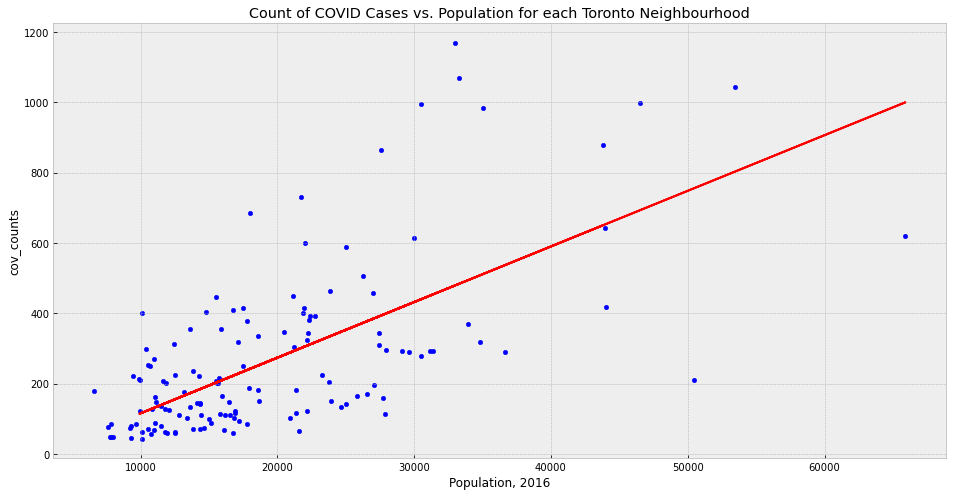

In [42]:
# plot each Neighborhood's COVID count against its population
fig, ax = plt.subplots(figsize=(16,8))
nbhd_cov.plot.scatter("Population, 2016", "cov_counts", ax=ax,
                      title='Count of COVID Cases vs. Population for each Toronto Neighbourhood');

# plot linear regression trend line
X_train, X_test, y_train, y_test = train_test_split(X_LR_simp, y)
LR_simp_model = LinearRegression().fit(X_train, y_train)
plt.plot(X_test, LR_simp_model.predict(X_test), 'r-');

## Multiple Linear Regression: Income, Age Demographics, Living Arrangements

In [43]:
# select the initial columns to include in the Muliple Linear Regression, based partly on
# the amount of their correlation with the 'COVID Cases per 100,000' column
nbhd_cov_norm.corr()['COVID Cases per 1000']

COVID Cases per 1000                              1.000000
Hospitalizations per 1000                         0.816324
Population                                        0.076177
Population Density                               -0.115986
Average Household Size                            0.416052
Fraction of Children (0-14 years)                 0.287480
Fraction of Youth (15-24 years)                   0.345817
Fraction of Working Age (25-54 years)            -0.241592
Fraction of Pre-retirement (55-64 years)         -0.084469
Fraction of Seniors (65+ years)                  -0.032356
Fraction of Older Seniors (85+ years)             0.053403
Fraction in Single-detached house                -0.145419
Fraction in Apartment buildings (5+ storeys)      0.014968
Fraction in Other attached dwelling              -0.217441
Fraction in 1-person Household                   -0.303585
Fraction in 2-persons Household                  -0.475153
Fraction in 3-person Household                    0.0115

Initially select the following features that show a correlation greater than +- 0.2.  Note that certain features with a correlation greater than +- 0.2 were not selected, based on the author's analysis of their interdependence and the extent of the correlation.

1. Average household size
2. Youth (15-24 years)
3. Single-detached house
4. Other attached dwelling
5. 1 persons
6. 2 persons
7. 5 or more persons
8. In the bottom half of the distribution
9. In low income based on the Low-income cut-offs, after tax (LICO-AT)

In [60]:
features_corr1 = [5, 7, 12, 14, 15, 16, 19, 20, 21]
y = nbhd_cov_norm.loc[:,'COVID Cases per 1000']
OLS_mult_model = sm.OLS(y, sm.add_constant(nbhd_cov_norm.iloc[:,features_corr1])).fit()
OLS_mult_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     COVID Cases per 1000   R-squared:                       0.588
Model:                              OLS   Adj. R-squared:                  0.560
Method:                   Least Squares   F-statistic:                     20.63
Date:                  Tue, 08 Dec 2020   Prob (F-statistic):           3.11e-21
Time:                          18:50:39   Log-Likelihood:                -432.59
No. Observations:                   140   AIC:                             885.2
Df Residuals:                       130   BIC:                             914.6
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             30.2503     22.388      1.351      0.179     -14.041      74.541
Average Household Size                           -11.8607      7.408     -1.601      0.112     -26.517       2.796
Fraction of Youth (15-24 years)                   82.4683     25.177      3.276      0.001      32.658     132.278
Fraction in Single-detached house                -12.8376     13.687     -0.938      0.350     -39.915      14.240
Fraction in Other attached dwelling              -10.6432      7.202     -1.478      0.142     -24.892       3.605
Fraction in 1-person Household                    49.2395     28.276      1.741      0.084      -6.702     105.181
Fraction in 2-persons Household                 -149.2155     57.208     -2.608      0.010    -262.396     -36.036
Fraction in 5+ person Household                  215.2544    137.157      1.569      0.119     -56.094     486.603
Fraction in bottom half of Income distribution    54.6896      7.705      7.098      0.000      39.446      69.933
Fraction in Low-income cut-offs (LICO-AT)       -111.5352     17.711     -6.297      0.000    -146.575     -76.495
==============================================================================
Omnibus:                       17.123   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.102
Skew:                           0.714   Prob(JB):                     1.59e-05
Kurtosis:                       4.323   Cond. No.                         834.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

The above results indicate that a number of the features aren't statistically significant.
The features with the highest P-values were removed one at a time to come up with the following features.

1. Youth (15-24 years)
2. 1 persons
3. 2 persons
4. In the bottom half of the distribution
5. In low income based on the Low-income cut-offs, after tax (LICO-AT)

In [78]:
features_corr2 =  [7, 15, 16, 20, 21]
X_LR_mult = nbhd_cov_norm.iloc[:,features_corr2]
# calculate p-values using statsmodel:
OLS_mult_model2 = sm.OLS(y, X_LR_mult).fit()
OLS_mult_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     COVID Cases per 1000   R-squared (uncentered):                   0.882
Model:                              OLS   Adj. R-squared (uncentered):              0.878
Method:                   Least Squares   F-statistic:                              202.5
Date:                  Tue, 08 Dec 2020   Prob (F-statistic):                    6.57e-61
Time:                          19:00:32   Log-Likelihood:                         -435.30
No. Observations:                   140   AIC:                                      880.6
Df Residuals:                       135   BIC:                                      895.3
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Fraction of Youth (15-24 years)                   86.3000     18.692      4.617      0.000      49.333     123.267
Fraction in 1-person Household                    87.8194     17.766      4.943      0.000      52.684     122.955
Fraction in 2-persons Household                 -171.0454     28.137     -6.079      0.000    -226.691    -115.400
Fraction in bottom half of Income distribution    56.9016      5.387     10.563      0.000      46.248      67.555
Fraction in Low-income cut-offs (LICO-AT)       -102.8373     15.009     -6.852      0.000    -132.520     -73.155
==============================================================================
Omnibus:                       16.840   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.296
Skew:                           0.715   Prob(JB):                     2.38e-05
Kurtosis:                       4.267   Cond. No.                         46.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
'''# predict the number of COVID cases in Toronto neighbourhoods based only these selected 8 features.
LR_mult_model = LinearRegression().fit(X_LR_mult, y)
y_LR_mult = LR_mult_model.predict(X_LR_mult)
LR_mult_RMSE = np.sqrt(mean_squared_error(y, y_LR_mult))
LR_mult_RMSE'''

'# predict the number of COVID cases in Toronto neighbourhoods based only these selected 8 features.\nLR_mult_model = LinearRegression().fit(X_LR_mult, y)\ny_LR_mult = LR_mult_model.predict(X_LR_mult)\nLR_mult_RMSE = np.sqrt(mean_squared_error(y, y_LR_mult))\nLR_mult_RMSE'

In [79]:
# carry out simple Linear Regression with single feature, neighbourhood "Population, 2016"
T = 500 # the number of loops to average the performance
rmse = 0
for t in range(T):
  rmse += model_LR(X_LR_mult, y)
rmse /= T
rmse

5.603068884169521

# Random Forests

The Random Forests regressor algorithm will be applied to the Neighbourhood data (input) in order to predict the number of COVID cases in each Neighbourhood.  The input features will be those listed in the X_RF dataframe listed below, and include Income, Age, Housing type, and Household size data.

In [91]:
X_RF = pd.concat([nbhd_cov_norm.iloc[:,4:22], nbhd_cov_norm.iloc[:,-1]], axis=1)

X_RF.drop('Average Household Size', axis=1, inplace=True)
X_RF.drop('Population Density', axis=1, inplace=True)
X_RF.head(1)

,Fraction of Children (0-14 years),Fraction of Youth (15-24 years),Fraction of Working Age (25-54 years),Fraction of Pre-retirement (55-64 years),Fraction of Seniors (65+ years),Fraction of Older Seniors (85+ years),Fraction in Single-detached house,Fraction in Apartment buildings (5+ storeys),Fraction in Other attached dwelling,Fraction in 1-person Household,Fraction in 2-persons Household,Fraction in 3-person Household,Fraction in 4-person Household,Fraction in 5+ person Household,Fraction in bottom half of Income distribution,Fraction in Low-income cut-offs (LICO-AT),Average after-tax Household Income
Characteristic,,,,,,,,,,,,,,,,,
129,0.1319,0.127263,0.388314,0.145296,0.207639,0.031773,0.114897,0.07282,0.125202,0.046371,0.081407,0.068526,0.060111,0.056504,0.636657,0.172947,427037


In [92]:
def model_RF(X, y, n):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model = RandomForestRegressor(n_estimators=n).fit(X_train, y_train)
    y_test_est = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_test_est))

In [93]:
'''# list of Number of Estimators to be used in Random Forest model
n_list = [50, 100, 150]
# note that calculation time increases greatly as n increases past 100 and 200.
T = 200 # the number of loops to average the performance
rmse = np.zeros(len(n_list))
for i, n in enumerate(n_list):
    for t in range(T):
      rmse[i] += model_RF(X_RF, y, n)
n_rmse = pd.DataFrame(rmse/T, index=n_list, columns=['RMSE'])
n_rmse.index.name = 'n'
fig, ax = plt.subplots(figsize=(12,6))
n_rmse.plot(ax=ax, title='Root mean squared error (RMSE) vs. Random Forests Number of Estimators (n)')
ax.grid();'''

"# list of Number of Estimators to be used in Random Forest model\nn_list = [50, 100, 150]\n# note that calculation time increases greatly as n increases past 100 and 200.\nT = 200 # the number of loops to average the performance\nrmse = np.zeros(len(n_list))\nfor i, n in enumerate(n_list):\n    for t in range(T):\n      rmse[i] += model_RF(X_RF, y, n)\nn_rmse = pd.DataFrame(rmse/T, index=n_list, columns=['RMSE'])\nn_rmse.index.name = 'n'\nfig, ax = plt.subplots(figsize=(12,6))\nn_rmse.plot(ax=ax, title='Root mean squared error (RMSE) vs. Random Forests Number of Estimators (n)')\nax.grid();"

Performance generally increases slightly as n increases, but the calculation time is too great to do a thorough analysis.

In [94]:
#
X_train, X_test, y_train, y_test = train_test_split(X_RF, y)
RF_model = RandomForestRegressor(n_estimators=150).fit(X_train, y_train)
y_train_RF = RF_model.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_train_RF))

2.2484295865438995

In [95]:
y_test_RF = RF_model.predict(X_test)
RF_rmse = np.sqrt(mean_squared_error(y_test, y_test_RF))
print(RF_rmse)

6.350024383632318


In [96]:
feat_importance = pd.Series(RF_model.feature_importances_, name = 'Imporance',
                            index = X_RF.columns)

In [97]:
feat_importance

Fraction of Children (0-14 years)                 0.073670
Fraction of Youth (15-24 years)                   0.041561
Fraction of Working Age (25-54 years)             0.017247
Fraction of Pre-retirement (55-64 years)          0.078849
Fraction of Seniors (65+ years)                   0.019993
Fraction of Older Seniors (85+ years)             0.032567
Fraction in Single-detached house                 0.021490
Fraction in Apartment buildings (5+ storeys)      0.012641
Fraction in Other attached dwelling               0.027726
Fraction in 1-person Household                    0.029479
Fraction in 2-persons Household                   0.106205
Fraction in 3-person Household                    0.015292
Fraction in 4-person Household                    0.020745
Fraction in 5+ person Household                   0.094200
Fraction in bottom half of Income distribution    0.349083
Fraction in Low-income cut-offs (LICO-AT)         0.013561
Average after-tax Household Income                0.0456

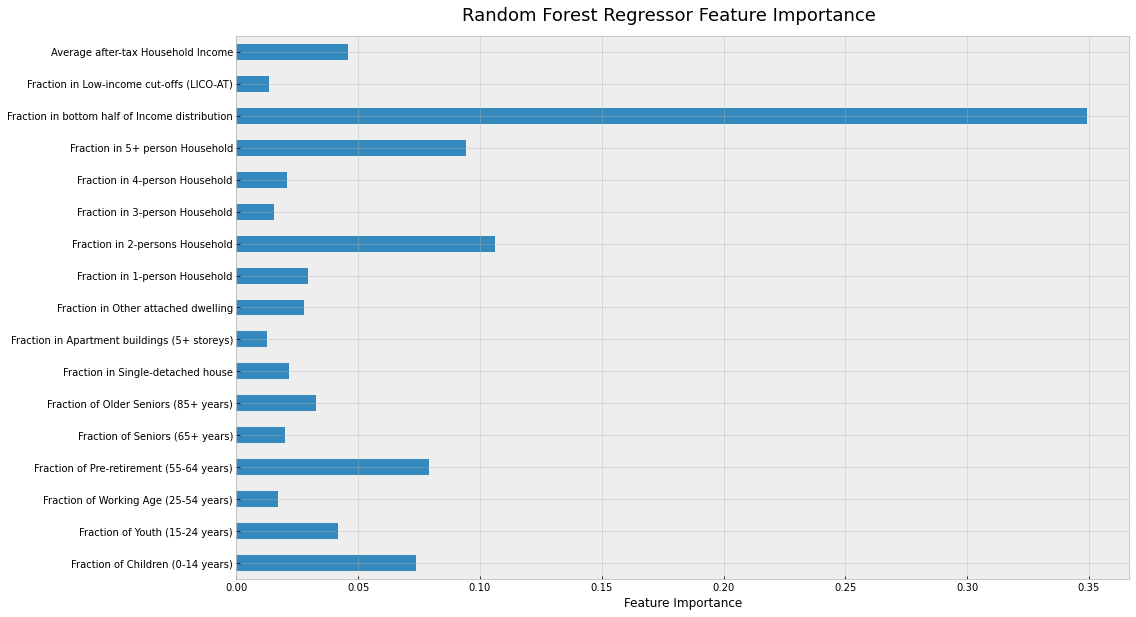

In [98]:
fig, ax = plt.subplots(figsize=(16,10))	
feat_importance.plot.barh(ax=ax);
ax.set_xlabel('Feature Importance')
fig.suptitle('Random Forest Regressor Feature Importance', y=0.92, fontsize=18);

# Neural Networks

Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0, 1] or [-1, +1], or standardize it to have mean 0 and variance 1. Note that you must apply the same scaling to the test set for meaningful results. You can use StandardScaler for standardization.
 
```
from sklearn.preprocessing import StandardScaler  # doctest: +SKIP
scaler = StandardScaler()  # doctest: +SKIP
# Don't cheat - fit only on training data
scaler.fit(X_train)  # doctest: +SKIP
X_train = scaler.transform(X_train)  # doctest: +SKIP
# apply same transformation to test data
X_test = scaler.transform(X_test)  # doctest: +SKIP
```

## Neural Networks with Reduced Feature Set

In [ ]:
X_NN2 = nbhd_cov_norm.iloc[:,3:23]
X_RF.drop('Average Household Size', axis=1, inplace=True)
X_RF.drop('Population Density', axis=1, inplace=True)
X_NN2

In [ ]:
param_grid = [{'activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [(1,),(2,)]}]
param_grid = [{'activation' : ['relu'], 'solver' : ['lbfgs'],
            'alpha' : [800, 900, 1000],
            'hidden_layer_sizes': [(30,), (40,), (50,)]}]
clf = GridSearchCV(MLPRegressor(max_iter=500000), param_grid, cv=3, # use cross-validation of 2 or 3 b/c data set is small
                           scoring='neg_root_mean_squared_error')

scaler = StandardScaler()
scaler.fit(X_NN2)
X_NN2n = scaler.transform(X_NN2)
clf.fit(X_NN2n, y)

print("Best parameters set found on development set:")
print(clf.best_params_)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_NN2, y)

scaler2 = StandardScaler()
# Don't cheat - fit only on training data
scaler2.fit(X_train)
Xn_train = scaler2.transform(X_train)
# apply same transformation to test data
Xn_test = scaler2.transform(X_test)

NN2_model = MLPRegressor(hidden_layer_sizes=(40,), solver='lbfgs', max_iter=1000000, alpha=1000,
                          activation='relu').fit(Xn_train, y_train)

y_train_NN = NN2_model.predict(Xn_train)
np.sqrt(mean_squared_error(y_train, y_train_NN))

In [ ]:
y_test_NN = NN2_model.predict(Xn_test)
NN2_rmse = np.sqrt(mean_squared_error(y_test, y_test_NN))
print(NN2_rmse)

## Neural Networks with Augmented Dataset

In [88]:
X_NN = nbhd_cov_norm.iloc[:,3:]
X_NN.drop('Average after-tax Household Income', axis=1, inplace=True)
X_NN.drop('Fraction in bottom half of Income distribution', axis=1, inplace=True)
X_NN.drop('Average Household Size', axis=1, inplace=True)
X_NN

,Population,Population Density,Fraction of Children (0-14 years),Fraction of Youth (15-24 years),Fraction of Working Age (25-54 years),Fraction of Pre-retirement (55-64 years),Fraction of Seniors (65+ years),Fraction of Older Seniors (85+ years),Fraction in Single-detached house,Fraction in Apartment buildings (5+ storeys),...,"Income $40,000 to $44,999","Income $45,000 to $49,999","Income $50,000 to $59,999","Income $60,000 to $69,999","Income $70,000 to $79,999","Income $80,000 to $89,999","Income $90,000 to $99,999","Income $100,000 to $124,999","Income $125,000 to $149,999","Income $150,000+"
Characteristic,,,,,,,,,,,,,,,,,,,,,
129,29113,3929,0.131900,0.127263,0.388314,0.145296,0.207639,0.031773,0.114897,0.072820,...,0.015629,0.016316,0.031944,0.025933,0.023872,0.021983,0.017174,0.032116,0.015972,0.017518
128,23757,3034,0.129436,0.141432,0.419455,0.137433,0.172791,0.023362,0.117439,0.132382,...,0.019784,0.018731,0.036200,0.031780,0.026518,0.021046,0.017048,0.029465,0.015574,0.017889
20,12054,2435,0.146010,0.102456,0.433051,0.151402,0.167164,0.026547,0.235606,0.021155,...,0.015348,0.018666,0.032354,0.029451,0.030280,0.025718,0.021984,0.050191,0.036917,0.038991
95,30526,10863,0.077311,0.122846,0.492695,0.114001,0.193605,0.034069,0.021130,0.267477,...,0.021130,0.021785,0.038000,0.034724,0.026862,0.024569,0.020311,0.039475,0.025552,0.090579
42,27695,2775,0.130168,0.098574,0.390323,0.128363,0.251851,0.059216,0.125835,0.226395,...,0.020040,0.020762,0.042607,0.036108,0.028525,0.024914,0.021484,0.037191,0.023831,0.069146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,14349,8541,0.129626,0.091992,0.447418,0.111158,0.219527,0.061328,0.064116,0.090250,...,0.019514,0.015681,0.034846,0.027877,0.026483,0.021256,0.017423,0.034497,0.021604,0.049132
100,11817,7162,0.152323,0.103664,0.495896,0.112127,0.135398,0.013963,0.118473,0.168825,...,0.020310,0.020310,0.040196,0.035119,0.029195,0.021579,0.020310,0.039350,0.027080,0.096048
97,12528,10708,0.096584,0.073436,0.475734,0.122925,0.231881,0.037516,0.041507,0.344428,...,0.026341,0.025144,0.049888,0.037915,0.035920,0.026740,0.024345,0.045498,0.027937,0.110951


In [89]:
scaler = StandardScaler()
scaler.fit(X_NN)
X_NNn = scaler.transform(X_NN)

In [90]:
param_grid = [{'activation' : ['relu'], 'solver' : ['lbfgs'],
            'alpha' : [900, 1000, 1100],
            'hidden_layer_sizes': [(20,), (25,), (30,)]}]

clf = GridSearchCV(MLPRegressor(max_iter=500000), param_grid, cv=3, # use cross-validation of 2 or 3 b/c data set is small
                           scoring='neg_root_mean_squared_error')
clf.fit(X_NNn, y)

print("Best parameters set found on development set:")
print(clf.best_params_)

Best parameters set found on development set:
{'activation': 'relu', 'alpha': 1000, 'hidden_layer_sizes': (20,), 'solver': 'lbfgs'}


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_NN, y)
scaler2 = StandardScaler()
# Don't cheat - fit only on training data
scaler2.fit(X_train)
Xn_train = scaler2.transform(X_train)
# apply same transformation to test data
Xn_test = scaler2.transform(X_test)
NN_model = MLPRegressor(hidden_layer_sizes=(25,), solver='lbfgs', max_iter=1000000, alpha=1000,
                          activation='relu').fit(Xn_train, y_train)
y_train_NN = NN_model.predict(Xn_train)
np.sqrt(mean_squared_error(y_train, y_train_NN))

73.66304838983417

In [92]:
y_test_NN = NN_model.predict(Xn_test)
NN_rmse = np.sqrt(mean_squared_error(y_test, y_test_NN))
print(NN_rmse)

114.77861020038422


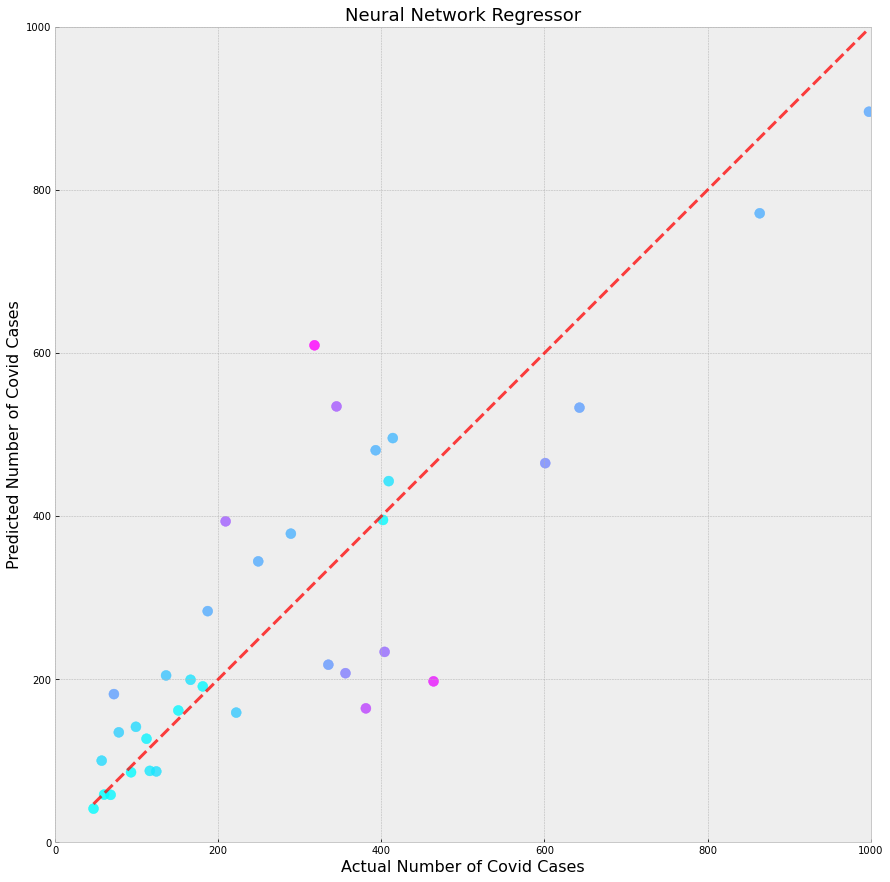

In [95]:
# visualizing the predictions
def plot_regression(y_true, y_pred, title="", axis_label=""):
  y_residual = np.abs(y_true-y_pred)
  fig, ax = plt.subplots(figsize=(20,15))
  scatter = ax.scatter(x=y_true, y=y_pred, c=y_residual, cmap="cool", marker="o", s=100, alpha=0.8)
  ax.set_xlabel("Actual %s"%axis_label, fontsize=16); ax.set_ylabel("Predicted %s"%axis_label, fontsize=16); 
  ax.set_title(title, fontsize=18);
  ax.set_xlim(0, 1000); ax.set_ylim(0, 1000);
  ax.set_aspect(1)
  ax.plot([np.min(y_true), np.max(y_true)], [np.min(y_true), np.max(y_true)], "r--", alpha=0.75, linewidth=3)

plot_regression(y_test, y_test_NN, title="Neural Network Regressor", axis_label="Number of Covid Cases")